In [49]:
import numpy as np
import cv2
from pylepton.Lepton3 import Lepton3
from utils.ir.utils import ktoc, vis2arr, ir2arr, normalize_ir, draw_box , detect_ir
from utils.ir.utils import drop_small_bboxes, overlay_bboxes
import matplotlib.pyplot as plt

In [51]:
from utils.ir.utils import calulate_temp

ImportError: cannot import name 'calulate_temp' from 'utils.ir.utils' (/home/pi/Lepton/pylepton/utils/ir/utils.py)

# Test Thermal Camera

In [9]:
def detect_ir(ir_arr, thr):
    """
    Detects objects above thr temperature in ir array
    :param ir_arr: ir array in deg. C
    :param thr: threshold temperature in deg. C
    """
    
    mask = ir_arr>thr
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    bboxes = []
    for c in contours:
        polygon = cv2.approxPolyDP(c, 3, True)
        bbox = cv2.boundingRect(polygon)
        bboxes.append(bbox)
    
    return bboxes

def drop_small_bboxes(bboxes, min_size):
    """
    :param min_size: min size of bb area [px]
    """
    good = []
    for (x, y, dx, dy) in bboxes:
        if dx*dy > min_size:
            good.append((x, y, dx, dy))
    return good

def overlay_bboxes(arr, bboxes):
    
    arr = cv2.normalize(arr, None, 0, 255, cv2.NORM_MINMAX)
    arr = arr.astype(np.uint8)
    arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    
    COL = (255, 255, 0)
    for (x, y, dx, dy) in bboxes:
        p1 = (x,y)
        p2 = (x+dx, y+dy)
        cv2.rectangle(arr,
                      p1,
                      p2,
                      color=COL,
                      thickness=2)
    return arr

In [2]:
def get_temp():
   with Lepton3() as l:
      ir_data, sum_ir_data = l.capture() 
      temp_arr = ktoc(ir_data)
      img = ir2arr(ir_data, size=(160,120))
      img = normalize_ir(img)
      # Remove small boxes
      bboxes_all = detect_ir(img, 42)
      bboxes_good = drop_small_bboxes(bboxes_all, min_size=1000)
      objects = []
      for box in bboxes_good:
         (x, y, dx, dy) = box
         # p1 = (x, y)
         # p2 = (x + dx, y + dy)
         objects.append((temp_arr[y : y + dy, x : x + dx], img[y: y + dy, x : x + dx]))
   return temp_arr, img, objects

In [18]:
temp_arr, img , objects = get_temp()

frame processed int 0.03716397285461426s, 26.907779852062845hz


In [19]:
len(objects)

1

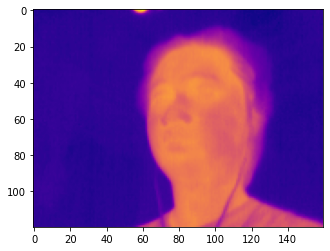

In [20]:
plt.imshow(img, cmap='plasma')

In [21]:
# plt.imsave("img/sample/plasma.png",img, cmap='plasma')


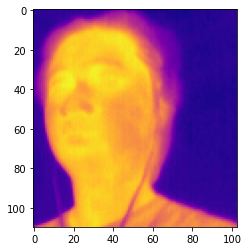

In [22]:
plt.imshow(objects[0][1], cmap='plasma')


In [24]:
temp_arr[20,90]

array([35.92])

# Test face detector

In [10]:
from tflite_runtime.interpreter import Interpreter
from detector.face_detector import ThermalFaceDetector

In [18]:
thermal_face_detector = Interpreter("model/thermal_face_automl_edge_fast.tflite")

In [92]:
thermal_face_detector.get_input_details()[0]["shape"][1]

192

In [4]:
thermal_face_detector.get_output_details()

[{'name': 'TFLite_Detection_PostProcess',
  'index': 506,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 507,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 508,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': 

In [77]:
def extract_TF_feature(lite_model, img, norm = False):
  # test_image = cv2.imread(img_path)
  thermal_img = img.copy()
  # thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2RGB)
  print(thermal_img.shape)
  thermal_img = cv2.resize(thermal_img, (192, 192), interpolation = cv2.INTER_NEAREST)
  
  # test_image = np.squeeze(test_image)
  # test_image = cv2.resize(test_image, (112,112),  interpolation = cv2.INTER_NEAREST)
  lite_model.allocate_tensors()
  input_details = lite_model.get_input_details()[0]
  output_details = lite_model.get_output_details()
  # if input_details['dtype'] == np.uint8:
  #       # print("a")
  #       input_scale, input_zero_point = input_details["quantization"]
  #       print(input_scale)
  #       print(input_zero_point)
  #       thermal_img = thermal_img / input_scale + input_zero_point
        # print(img)
  thermal_img = thermal_img.astype(input_details["dtype"])
  thermal_img = np.expand_dims(thermal_img, axis=0)
  lite_model.set_tensor(input_details["index"], thermal_img)
  lite_model.invoke()
  boxes = lite_model.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
  classes = lite_model.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
  scores = lite_model.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects
  num = lite_model.get_tensor(output_details[3]['index'])[0]  # Total number of detected objects (inaccurate and not needed)
  # print(TF_output)
#   if output_details["dtype"] == np.uint8:
#         # print("b")
#         output_scale, output_zero_point = output_details["quantization"]
#         print(output_scale)
#         print(output_zero_point)
#         TF_output = TF_output.astype(np.float32)
#         TF_output = output_scale * (TF_output - output_zero_point)
#   if norm :
#     TF_norm = np.sqrt(np.sum(TF_output*TF_output)+0.00001)
#     TF_output /= TF_norm
  return boxes, classes, scores, num

In [ ]:

input_mean = 128
input_std = 127.5


In [30]:
img_3d = img[:, :, None] * np.ones(3, dtype=int)[None, None, :]

In [31]:
img_3d.shape

(120, 160, 3)

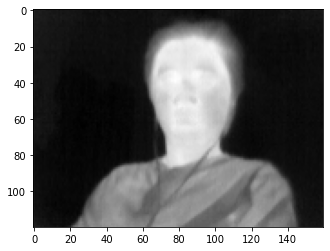

In [35]:
plt.imshow(img_3d)

In [89]:
img_3d = img[:, :, None] * np.ones(3, dtype=int)[None, None, :]
# img_3d = cv2.imread("img/sample/plasma.png")
# img_3d = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)
print(img_3d.shape)
# img_3d = cv2.resize(img_3d, (192, 192), interpolation = cv2.INTER_NEAREST)
imH, imW, _ = img_3d.shape 

boxes, classes, scores, num = extract_TF_feature(thermal_face_detector, img_3d)
min_conf_threshold = 0.4
for i in range(len(scores)):
    if ((scores[i] >= min_conf_threshold) and (scores[i] <= 1.0)):

        # Get bounding box coordinates and draw box
        # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
        ymin = int(max(1,(boxes[i][0] * imH)))
        xmin = int(max(1,(boxes[i][1] * imW)))
        ymax = int(min(imH,(boxes[i][2] * imH)))
        xmax = int(min(imW,(boxes[i][3] * imW)))
        
        cv2.rectangle(img_3d, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

        # Draw label
        object_name = "face" # Look up object name from "labels" array using class index
        label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
        label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
        # cv2.rectangle(img_3d, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
        # cv2.putText(img_3d, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

(120, 160, 3)
(120, 160, 3)


In [11]:
face_detector = ThermalFaceDetector("model/thermal_face_automl_edge_fast.tflite")

In [25]:
img_3d = img[:, :, None] * np.ones(3, dtype=int)[None, None, :]
boxes, classes, scores, num = face_detector(img_3d)

In [26]:
min_conf_threshold = 0.5
img = draw_box(img_3d.copy(), boxes, scores, classes, num, min_conf_threshold)

In [29]:
imH, imW, _ = img_3d.shape 
for i in range(len(scores)):
    if ((scores[i] >= min_conf_threshold) and (scores[i] <= 1.0)):

        # Get bounding box coordinates and draw box
        # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
        ymin = int(max(1,(boxes[i][0] * imH)))
        xmin = int(max(1,(boxes[i][1] * imW)))
        ymax = int(min(imH,(boxes[i][2] * imH)))
        xmax = int(min(imW,(boxes[i][3] * imW)))
        
        face = img.copy()[ymin:ymax, xmin:xmax]
        # cv2.rectangle(img_3d, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

In [31]:
b = temp_arr[ymin:ymax, xmin:xmax]

In [63]:
def find_nth_smallest(a, n):
    return np.partition(a, n-1)[n-1]

def calulate_temp(temp_arr, thresh_temp, bboxes):
    xmin, ymin, xmax, ymax = bboxes
    temp_area = temp_arr.copy()[ymin:ymax, xmin:xmax]
    temp_area[temp_area < thresh_temp] = 0
    max_temp =  np.max(temp_area)
    # min_temp = find_nth_smallest(temp_area, 2)
    num_exceed_thresh = len(np.where(temp_area > thresh_temp)[0])
    mean_temp = np.sum(temp_area) / num_exceed_thresh
    return  max_temp, mean_temp

In [64]:
calulate_temp(temp_arr, 34, (xmin, ymin, xmax, ymax) )

(36.93, 35.5606376894481)

In [60]:
len(np.where(b > 36)[0])

897

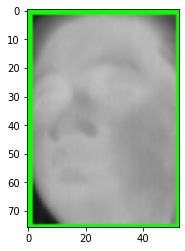

In [30]:
plt.imshow(face)


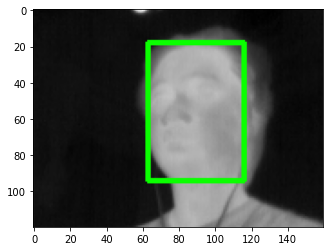

In [27]:
plt.imshow(img)

In [86]:
boxes

array([[0.1396173 , 0.4338072 , 0.6588801 , 0.6777684 ],
       [0.05185497, 0.08973764, 0.8143266 , 0.38273656],
       [0.07636762, 0.85582274, 0.83456683, 0.98029166],
       ...,
       [0.6601758 , 0.44172   , 1.2021986 , 0.7020333 ],
       [0.4006867 , 0.41771865, 0.6029415 , 0.46830767],
       [0.74080306, 0.6886556 , 0.9888434 , 0.7651789 ]], dtype=float32)

In [87]:
classes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [88]:
scores

array([0.57421875, 0.078125  , 0.06640625, 0.05859375, 0.04296875,
       0.04296875, 0.04296875, 0.04296875, 0.0390625 , 0.0390625 ,
       0.0390625 , 0.03515625, 0.03515625, 0.02734375, 0.02734375,
       0.0234375 , 0.0234375 , 0.0234375 , 0.0234375 , 0.0234375 ,
       0.0234375 , 0.0234375 , 0.0234375 , 0.0234375 , 0.0234375 ,
       0.0234375 , 0.0234375 , 0.0234375 , 0.01953125, 0.01953125,
       0.01953125, 0.01953125, 0.01953125, 0.01953125, 0.01953125,
       0.01953125, 0.01953125, 0.01953125, 0.01953125, 0.01953125,
       0.01953125, 0.01953125, 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.015625  ,
       0.015625  , 0.015625  , 0.015625  , 0.015625  , 0.01562

In [55]:
num

500.0